# Emotion Detection from scratch


**Description:** Training an image classifier from scratch on the Kaggle FER-2013 Dataset.

# Data Set-

Kaggle - https://www.kaggle.com/datasets/msambare/fer2013
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)


# Setting up Kaggle Directory

In [ ]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 98% 59.0M/60.3M [00:02<00:00, 41.5MB/s]
100% 60.3M/60.3M [00:02<00:00, 29.4MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

# Installing Packages

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Data Cleaning

In [ ]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)

# Data Analysis

In [ ]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/train'
test_dir = '/content/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


       fear  disgust  neutral   sad  surprise  happy  angry
train  4097      436     4965  4830      3171   7215   3995
      fear  disgust  neutral   sad  surprise  happy  angry
test  1024      111     1233  1247       831   1774    958


<Axes: >

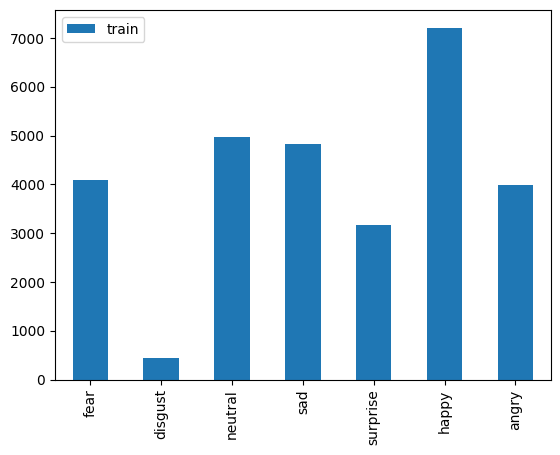

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

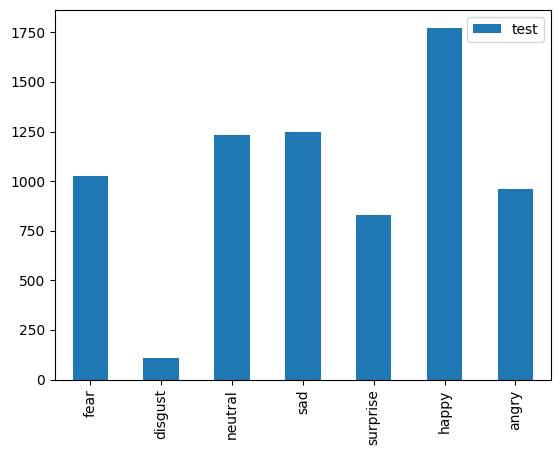

In [ ]:
test_count.transpose().plot(kind='bar')

# Plotting one image from each emotion.

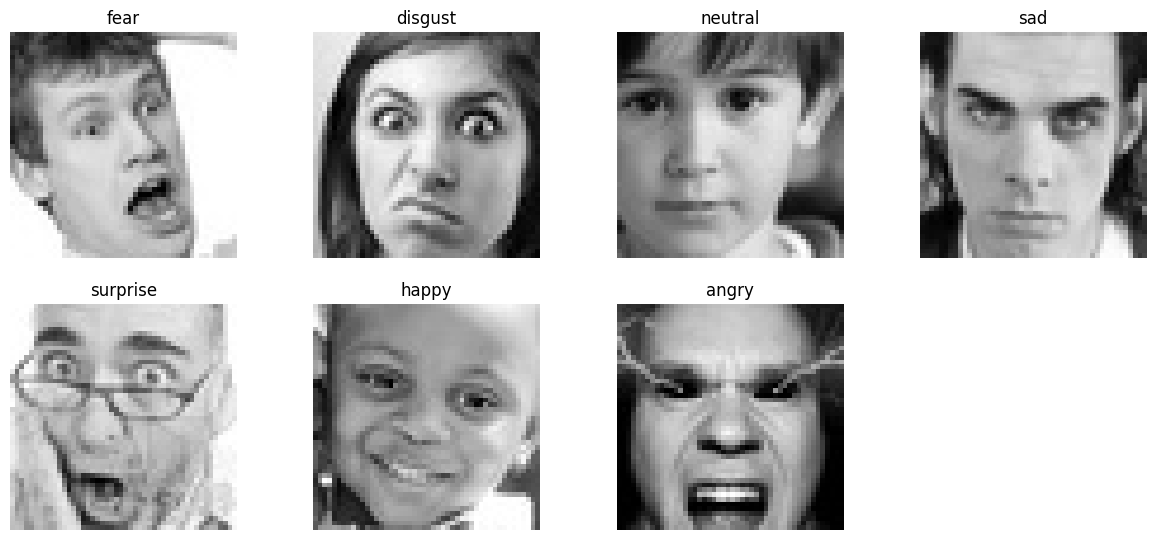

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

# Plotting random images from given directory

In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

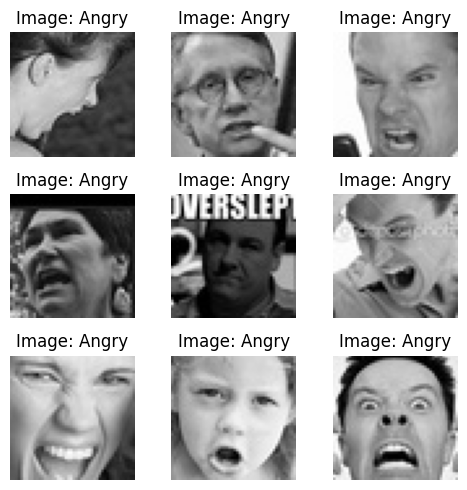

In [ ]:
# Placeholder for the directory path
angry_directory_path = '/content/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

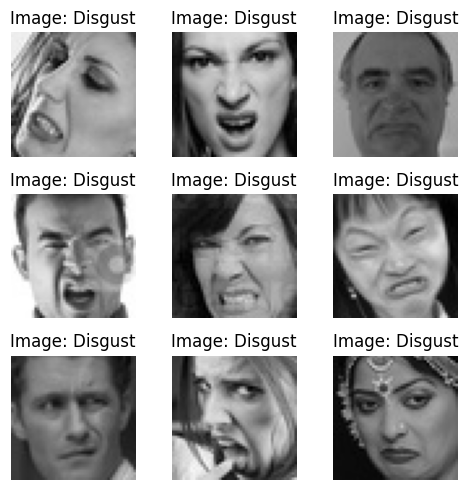

In [ ]:
# Placeholder for the directory path
disgust_directory_path = '/content/train/disgust'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

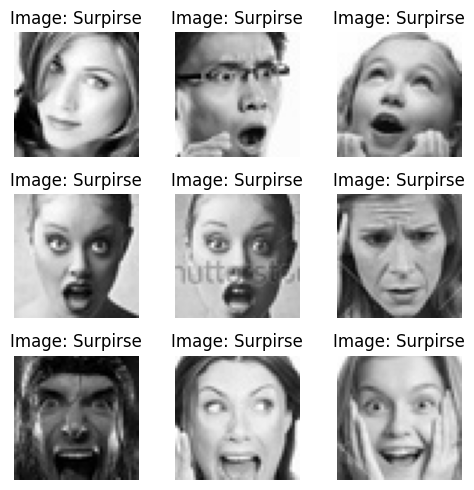

In [ ]:
# Placeholder for the directory path
surpirse_directory_path = '/content/train/surprise'  # Replace with your directory path
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

# Checking shapes and channels.

In [ ]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [ ]:
import cv2

image_path = '/content/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Plotting Performance Metrics

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Model 3: Transfer Learning VGGNET

In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                shear_range=0.2,
                                brightness_range=[0.8, 1.2]
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
classes

7

In [ ]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=01e-6, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,934,215 (156.15 MB)

 Trainable params: 30,939,143 (118.02 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=01e-6, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/Colab Notebooks/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=70,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
                    )

Epoch 1/70
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4635 - loss: 1.3707
Epoch 1: val_loss improved from inf to 1.31343, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.4635 - loss: 1.3707 - val_accuracy: 0.4971 - val_loss: 1.3134 - learning_rate: 1.0000e-06
Epoch 2/70
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:23 321ms/step - accuracy: 0.4531 - loss: 1.2000

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.31343
448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4531 - loss: 1.2000 - val_accuracy: 0.5000 - val_loss: 1.3519 - learning_rate: 1.0000e-06
Epoch 3/70
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.4588 - loss: 1.3904
Epoch 3: val_loss improved from 1.31343 to 1.30436, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.4588 - loss: 1.3903 - val_accuracy: 0.5035 - val_loss: 1.3044 - learning_rate: 1.0000e-06
Epoch 4/70
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:21 316ms/step - accuracy: 0.5156 - loss: 1.3379
Epoch 4: val_loss did not improve from 1.30436
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5156 - loss: 1.3379 - val_accuracy: 0.5000 - val_loss: 1.3273 - learning_rate: 1.0000e-06
Epoch 5/70
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 982ms/step - accuracy: 0.4707 - loss: 1.3709
Epoch 5: val_loss improved from 1.30436 to 

KeyboardInterrupt: 

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

449/449 ━━━━━━━━━━━━━━━━━━━━ 384s 855ms/step - accuracy: 0.4756 - loss: 1.3654
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 250ms/step - accuracy: 0.4831 - loss: 1.3399
final train accuracy = 47.40 , validation accuracy = 48.69


113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 232ms/step


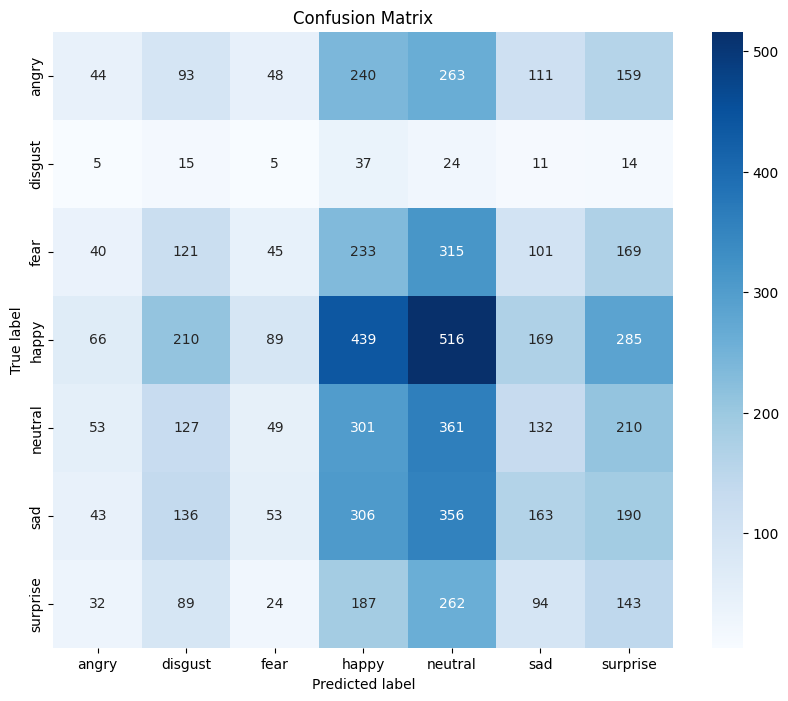

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
step = int(np.ceil(test_generator.samples/test_generator.batch_size))
predicted_classes = np.argmax(model.predict(test_generator, steps=step), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.16      0.05      0.07       958
     disgust       0.02      0.14      0.03       111
        fear       0.14      0.04      0.07      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.17      0.29      0.22      1233
         sad       0.21      0.13      0.16      1247
    surprise       0.12      0.17      0.14       831

    accuracy                           0.17      7178
   macro avg       0.15      0.15      0.13      7178
weighted avg       0.18      0.17      0.16      7178



# Deployement

# Gradio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install gradio

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

In [ ]:
# Ensure your model is loaded here
# model = ... # Load your trained model
# Load your pre-trained model
model = tf.keras.models.load_model('/content/drive/MyDrive/Emotion_Detection/Final_Resnet50_Best_model.keras')

In [ ]:
# Emotion labels dictionary
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
index_to_emotion

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [ ]:
def prepare_image(img_pil):
    """Preprocess the PIL image to fit your model's input requirements."""
    # Convert the PIL image to a numpy array with the target size
    img = img_pil.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Convert single image to a batch.
    img_array /= 255.0  # Rescale pixel values to [0,1], as done during training
    return img_array



# Define the Gradio interface
def predict_emotion(image):
    # Preprocess the image
    processed_image = prepare_image(image)
    # Make prediction using the model
    prediction = model.predict(processed_image)
    # Get the emotion label with the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    predicted_emotion = index_to_emotion.get(predicted_class[0], "Unknown Emotion")
    return predicted_emotion

interface = gr.Interface(
    fn=predict_emotion,  # Your prediction function
    inputs=gr.Image(type="pil"),  # Input for uploading an image, directly compatible with PIL images
    outputs="text",  # Output as text displaying the predicted emotion
    title="Emotion Detection",
    description="Upload an image and see the predicted emotion."
)

# Launch the Gradio interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://eb53f8c30e2eca7f49.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
